In [40]:
!pip install llama-index-core llama-parse llama-index-readers-file python-dotenv lancedb pandas sentence_transformers ace_tools langchain-openai langchain-community Levenshtein

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">

در این بخش از کد بعد از نصب کتابخانه های مورد نیاز به گوگل درایو متصل شدم و  بعد از آن به سراغ استفاده از parser رفتم. در این مرحله ابتدا کلید apillama parser را مقدار دهی کردم و آدرس فایل کتاب مورد نظر را هم مشخص کردم.
سپس کتاب مورد نظر را با استفاده از parser به تکست تبدیل کردم. پارسر هر صفحه کتاب را به یک تکست تبدیل کرده است به همین دلیل با متن ها را به صورت chunk جدا کردم و داخل دیتا فریم ریختم.

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
import re

os.environ["LLAMA_CLOUD_API_KEY"] = "llx-Aqvil4BxJqZsClIYPHEOHkPI85mrUnnXiPolZSH6pXpieJ7m"

parser = LlamaParse(api_key=os.environ["LLAMA_CLOUD_API_KEY"], result_type="text")

file_extractor = {".pdf": parser}
file_path = ["/content/drive/My Drive/nlp_ca6/The_New_Complete_Book_of_Foos.pdf"]

data_for_parse = SimpleDirectoryReader(input_files=file_path, file_extractor=file_extractor)
data_for_parse

In [7]:
documents =data_for_parse.load_data()

documents

Started parsing the file under job_id e96a593c-69e6-4e45-9b79-8a77818e6e9d


[Document(id_='0ce68a1d-45e7-4689-b94d-da828227af8b', embedding=None, metadata={'file_path': '/content/drive/My Drive/nlp_ca6/The_New_Complete_Book_of_Foos.pdf', 'file_name': 'The_New_Complete_Book_of_Foos.pdf', 'file_type': 'application/pdf', 'file_size': 2255541, 'creation_date': '2025-02-06', 'last_modified_date': '2025-01-05'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='The New\nComplete Book of\nFOOD\n   5 eE0 n d   Edltlon\n A Nutritional, Medical,           and Culinary Guide\n     CAROL ANN RINZLER\n   Introduction by Jane E. Brody\n Foreword by Manfred Kroger; PhD.', path=None, url=None, mimetype=None), image_resource=None, a

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

In [9]:
documents_list = []
page_number = 0
last_doc = None
for doc in documents:
    if last_doc is None or last_doc != doc.metadata["file_name"]:
        page_number = 1
        last_doc = doc.metadata["file_name"]
    else:
        page_number += 1

    texts = text_splitter.split_text(doc.text)
    for text in texts:
        item = {}
        item["text"] = text
        item["metadata_file_name"] = doc.metadata["file_name"]
        item["metadata_creation_date"] = doc.metadata["creation_date"]
        item["metadata_pagenumber"] = page_number
        documents_list.append(item)



In [10]:
import pandas as pd

df = pd.DataFrame(documents_list)
df

,text,metadata_file_name,metadata_creation_date,metadata_pagenumber
0,The New\nComplete Book of\nFOOD\n 5 eE0 n d ...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,1
1,The New\nFood\n Complete Book of\n S e c ...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,2
2,NO_CONTENT_HERE,The_New_Complete_Book_of_Foos.pdf,2025-02-06,3
3,The New\nFood\n Complete Book of\n S e c...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,4
4,"The New Complete Book of Food, Second Edition\...",The_New_Complete_Book_of_Foos.pdf,2025-02-06,5
...,...,...,...,...
1732,"strawberries 369, 372 with cabbage ...",The_New_Complete_Book_of_Foos.pdf,2025-02-06,497
1733,deficiency of 237 water softeners ...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,497
1734,"184, 213, 261 wheat substitutes ...",The_New_Complete_Book_of_Foos.pdf,2025-02-06,497
1735,RDA of xviii white poultry me...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,497


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">

در این مرحله سعی کردم داده های کتاب را که به صورت متن ذخیره شده در embedding database lancedb قرار بدم که بتوانیم از آن برای جستجوی اسناد مرتبط با کوئری کاربر استفاده کنیم تا چت بات بتواند بر اساس این اسناد جواب مرتبط با سوال کاربر را جنریت کند.
برای این کار کتابخانه lancedb را ایمپورت کردم و آدرس دیتا بیس را تنظیم کردم. همچنین مدل امبدینگ مورد نیاز رو تعریف کردم و اسکیمای مورد نظر برای دیتا بیس رو با استفاده از کلاس Chunks0fData مشحص کردم. با استفاده از تابعی که در ورکشاپ استفاده شده بود انتقال دیتا ها به دیتابیس را به صورت batch تعریف کردم.
در مرحله بعد جدول مربوط به دیتا بیس را ساختم و داده ها را به دیتا بیس انتقال دادم  و تکست کتاب را نیز با استفاده از ابزار های lancedb وکتورایز کردم. در ادامه هم برای اطمینان از روند درست انجام کار ۵ سند مرتبط با کوئری how can i make pizza را جستجو کردم.

In [12]:
import lancedb
db = lancedb.connect(".lancedb")
from lancedb.embeddings import get_registry
embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5", device="cuda")
from lancedb.pydantic import LanceModel, Vector

class ChunksOfData(LanceModel):
    text: str = embedding_model.SourceField()
    metadata_file_name: str
    metadata_creation_date: str
    metadata_pagenumber: int
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()

def df_to_dict_batches(df: pd.DataFrame, batch_size: int = 128):

    for start_idx in range(0, len(df), batch_size):
        end_idx = start_idx + batch_size
        batch_dicts = df.iloc[start_idx:end_idx].to_dict(orient="records")
        yield batch_dicts

tbl = db.create_table(
    "embedded_chunks55",
    data=df_to_dict_batches(df, batch_size=10),
    schema=ChunksOfData,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
query = "how can i make pizza"
res= tbl.search(query).limit(5).to_pandas()
res

,text,metadata_file_name,metadata_creation_date,metadata_pagenumber,vector,_distance
0,1 cup of water before cooking.)\n Heart. ...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,427,"[-0.015785377, 0.05463337, 0.059104122, 0.0021...",0.640302
1,Preparing This Food\nWash the pumpkin under co...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,351,"[0.031700652, -0.02267438, 0.011531868, 0.0006...",0.659816
2,Preparing This Food\n Brains. First wash...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,427,"[-0.010831897, 0.005769296, 0.014378329, -0.00...",0.660928
3,"pry open the shell, strain the liquid for any ...",The_New_Complete_Book_of_Foos.pdf,2025-02-06,374,"[0.019564532, -0.022392048, 0.005765951, -0.11...",0.664126
4,Preparing This Food\nRinse the sprouts thoroug...,The_New_Complete_Book_of_Foos.pdf,2025-02-06,51,"[0.01580018, 0.031527493, 0.009235176, -0.0075...",0.666678


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
در این قسمت از کد سعی کردم با استفاده از sqlite3 به دیتابیس موجود در فایل سوال متصل یشم و نام جدول های درون این دیتابیس رو استخراج کردم.
و در مرحله بعد نیز نمونه ای از داده ها را چاپ کردم که از آن ها جهت تست چت بات استفاده کنم.


In [15]:
import sqlite3

db_path = "/content/drive/My Drive/nlp_ca6/food_orders.db"


conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("tables:", tables)

conn.close()

tables: [('food_orders',), ('sqlite_sequence',), ('foods',)]


In [39]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(db_path)


query = "SELECT * FROM food_orders"
df_orders = pd.read_sql_query(query, conn)


print("`food_orders`:")
print(df_orders)

query = "SELECT * FROM foods"
df_foods = pd.read_sql_query(query, conn)

print("`foods`:")
print(df_foods)


conn.close()

`food_orders`:
    id person_name person_phone_number       status  \
0    1       Alice        123-456-7890     canceled   
1    2         Bob        987-654-3210     delivery   
2    3     Charlie        555-666-7777     canceled   
3    4       Diana        444-333-2222    delivered   
4    5         Eve        222-333-4444     canceled   
..  ..         ...                 ...          ...   
67  68      Julian        098-321-7656    delivered   
68  69    Scarlett        109-432-8767  preparation   
69  70        Levi        210-543-9878     delivery   
70  71       Layla        321-654-0980     canceled   
71  72      Nathan        432-765-1091    delivered   

                   order_description                        comment  
0            Kebab and Chicken Kebab                It was not good  
1            Pizza and Fried Chicken                                 
2                      Sushi platter                  Payment issue  
3               Burger and Ice Cream        

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">

سپس در این مرحله آدر provider مدل مورد نظر رو وارد کردم و مدل زبانی که میخواستم استفاده کنم را هم مشخص کردم و با استفاده از کتابخانه ChatOpenAI کلاینت مربوط به اتصال به مدل با استفاده از api را ساختم.

In [18]:
import os
from langchain_openai import ChatOpenAI

AVALAI_BASE_URL = "https://api.avalai.ir/v1"
GPT_MODEL_NAME = "gpt-4o-mini"

gpt4o_chat = ChatOpenAI(model=GPT_MODEL_NAME,
                        base_url=AVALAI_BASE_URL,
                        api_key="aa-NYbGWi06TiUnxZCpKCHTNyzrsSlLAerJlVfRknrCuNcGkic2")

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">


در این قسمت من ابزار های مورد استفاده از چت بات رو ساختم که از کد های موجود در فایل db_anager هم برای ساخت این ابزار ها و دسترسی به دیتابیس استفاده کردم که در ادامه هر کدام را جداگانه توضیح می دهم.

----------------------------------------------------------

ابزار food_recommendation:

این ابزار وظیفه پیشنهاد غذا را برعهده دارد و برای زمانی که کاربر مثلا درخواست میکند که i want spicy food از این ابزار استفاده می شود.
ایده من برای این ابزار این بود که مدل با استفاده از کوئری کاربر و با توجه به نوع غذایی که کاربر میخواهد داشته باشد، یک سری نام غذای متنوع جنریت کند و سپس این غذا ها را در دیتابیس جست و جو کند تا مشخصات مربوط به این غذا ها مانند قیمت و رستوران ارائه دهنده این غذا را به کاربر پیشنهاد دهد.
به همین منظور من استراکچر جواب مورد انتظار از مدل را با استفاده از کلاس FoodRecommendationOutput مشخص کردم که در آن نوع غذا مشخص می شود و لیستی از نام غذا ها را مدل جنریت می کند همچنین مدل دلیل خود برای انتخاب این غذا ها را هم ذکر می کند. سپس این تابع به این صورت کار میکند که با یک پرامپت از مدل میخواد بین ۵ تا ۱۰ غذای متنوع با توجه به نوع غذای خواسته شده توسط کاربر را جنریت کند و با فرمت مشخص خروجی دهد. سپس به دیتا بیس متصل شده و از بین این غذاهای جنریت شده اطلاعات ۵ غذا را به صورت رندم خروجی می دهد. این اطلاعات شامل غذا، رستوران ارائه دهنده و قیمت هستند.


-----------------------------------------------------------

order_management:

این ابزار وظیفه کنسل کردن، نوشتن کامنت و اطلاع از وضعیت سفارش مشتریان را بر عهده دارد. در اولین قدم من با استفاده از regex تابع is_valid_phone_number را تعریف کردم که مدل چک کند آیا شماره تلفن وارد شده توسط کاربر با فرمت شماره های درون دیتابیس همخوانی دارد یا نه.
سپس خود ابزار مدیریت سفارش را تعریف کردم. این ابزار به این صورت کار میکند که هر کدام از وظایف به صورت اکشن مشخص شده اند و بنا به تشخیص مدل که کاربر کدام اکشن را میخواد آن اکشن اجرا می شود. برای لغو سفارش غذا به این صورت است ک ابتدا مدل از کاربر درخواست شماره تلفن و شماره سفارش را می کند و در شماره تلفن وارد شده توسط کاربر را با فرمت مشخص شده تظابق میدهد و در صورت وارد شدن شماره تلفن اشتباه از کاربر میخواهد که شماره تلفن صحیح را وارد کند. در مرحله بعد به دیتابیس متصل شده و سفارش مورد نظر را جستجو میکند. اگر شماره سفارش با شماره تلفن همخوانی نداشته باشد این موضوع را به کاربر اعلام میکند. همچنین اگر شماره تلفن و شماره سفارش درست بود از کاربر می پرسد که آیا مطمئن است میخواد سفارش را لغو کند؟ و اگر جواب کاربر مثبت بود و اگر وضعیت سفارش preparation بود سفارش را لغو میکند در غیر این صورت به کاربر اطلاع میدهد که به دلیل delivered بودن و یا canceled بودن سفارش امکان لغو آن وجود ندارد.


ابزار چک کرد وضعیت سفارش نیز به این صورت کار میکند که شماره سفارش را از کاربر دریافت میکند و اگر شماره سفارش معتبر بود پضعیت آن سفارش را به کاربر اطلاع می دهد. همچنین برای گذاشتن کامنت برای سفارش نیز مدل از کاربر درخواست شماره تلفن، نام و شماره سفارش میکند و بعد از بررسی اطلاعات با اتصال به دیتابیس کامنت مورد نظر کاربر را ثبت میکند و پیام تایید این ثبت را خروجی می دهد.

-----------------------------------------------------------

lancedb_search:

این ابزار به منظور جستجو در پایگاه داده برداری نوشته شده و به این صورت عمل میکند که با استفاده از متد جستجوی lancedb و بر اساس شباهت کسینوسی بین کوئری کاربر و اسناد موجود در دیتابیس، ۵ سندی که کمترین فاصله و یا بیشترین شباهت را به کوئری کاربر دارند باز میگرداند.

----------------------------------------------------------

web_search:

این ابزار نیز به منظور جستجوی مدل در اینترنت نوشته شده است و به این صورت کار میکند که با استفاده از ایزار tavily کوئری کاربر را در اینترنت جستجو میکند و ۴ نتیجه برتر را به مدل باز میگرداند تا مدل پاسخ مناسب کوئری کاربر را بر اساس اسناد بازیابی شده جنریت کند.


** شایان ذکر است که با توجه به اینکه مدل دو ابزار جست و جو در دسترس دارد و ابزار جستجو در دیتابیس lancedb از اولویت برخوردار است این موضوع در ادامه توسط پرامپت به مدل گفته شده که اگر هدف کاربر جستجو بود ابتدا از ابزار lancedb_search استفاده کند و اگر اسناد بازیابی شده از این ابزار با کوئری کاربر بنا به تشخیص مدل مرتبط نبود از ابزار web_search استفاده کند.



-----------------------------------------------------------



food_search:


 این ابزار جهت جستجوی غذای مورد نظر کاربر در دیتابیس نوشته شده است و به این صورت عمل میکند که غذای مورد نیاز کاربر را با غذا های درون دیتابیس بر اساس فاصله لونشتاین مقایسه میکند و موارد نزذیک تر به غذای خواسته شده توسط کاربر را برای خروجی به مدل میدهد من برای این ابزار از کد درون فایل db_manager استفاده کردم.


 ----------------------------------------------------------


 در نهایت هم لیست ابزار های مدل را مشخص کردم و با استفاده از ابزار bind ابزار ها را به مدل معرفی کردم و llm_with_tools مدل همراه با آگاهی در مورد ابزار ها است.


In [21]:
import os
import sqlite3
import getpass
import atexit
import re
from typing import List
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_core.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
import Levenshtein


class FoodRecommendationOutput(BaseModel):
    """
    Structured output for food recommendations.
    """
    food_type: str = Field(description="The inferred general category of food from the user's request.")
    specific_dishes: list[str] = Field(description="A list of specific dish names within this category.")
    reasoning: str = Field(description="Explanation of why this food type was chosen.")

def food_recommendation(user_query: str):
    """
    Infers food preferences using LLM, then searches the database for multiple matching dishes.

    :param user_query: The user's request for food suggestions.
    :return: A natural language response with recommended dishes, restaurant names, and prices.
    """

    print("LLM is analyzing:", user_query)

    analysis_prompt = (
        "The user wants food recommendations. Determine the general type of food they are looking for, "
        "and provide a list of 6-10 specific dish names that belong to this category.\n"
        "User request: {user_query}\n"
        "Respond in structured JSON format."
    )

    llm_with_structured_output = gpt4o_chat.with_structured_output(FoodRecommendationOutput)
    response = llm_with_structured_output.invoke(user_query)

    food_type = response.food_type
    specific_dishes = response.specific_dishes
    reasoning = response.reasoning
    print(f"Inferred food type: {food_type}")
    print(f" Reasoning: {reasoning}")
    print(f" Searching for: {specific_dishes}")


    connection = sqlite3.connect('/content/drive/My Drive/nlp_ca6/food_orders.db')
    cursor = connection.cursor()

    query = """
        SELECT food_name, restaurant_name, price
        FROM foods
        WHERE food_category LIKE ?
        ORDER BY RANDOM()
        LIMIT 5;
    """

    cursor.execute(query, (f"%{food_type}%",))
    results = cursor.fetchall()

    if not results:
        placeholders = ', '.join('?' * len(specific_dishes))
        query = f"""
            SELECT food_name, restaurant_name, price
            FROM foods
            WHERE food_name IN ({placeholders})
            ORDER BY RANDOM()
            LIMIT 5;
        """
        cursor.execute(query, specific_dishes)
        results = cursor.fetchall()

    connection.close()


    if not results:
        return (
            f"Based on your request, I suggest trying **{food_type}** dishes. "
            "Unfortunately, I couldn't find exact matches in my database, but you can check nearby restaurants!"
        )

    response_text = f" Based on your preference, here are some **{food_type}** dishes available:\n\n"
    for food, restaurant, price in results:
        response_text += f"**{food}** at *{restaurant}* - **${price:.2f}**\n"

    response_text += "\nWould you like me to place an order for any of these dishes?"

    return response_text



def is_valid_phone_number(phone_number: str) -> bool:
    """
    Validates if the phone number follows the format: 555-666-7777.
    """
    import re
    pattern = r"^\d{3}-\d{3}-\d{4}$"
    return bool(re.match(pattern, phone_number))

def order_management(action: str, order_id: str = None, phone_number: str = None,
                          person_name: str = None, comment: str = None):
    """
    Manages orders, including checking status, canceling orders, and adding comments.

    :param action: The action to perform ('check_status', 'cancel', 'add_comment').
    :param order_id: The order ID (required for all actions).
    :param phone_number: The user's phone number (required for canceling an order).
    :param person_name: The person's name (required for adding a comment).
    :param comment: The comment text (required for adding a comment).
    :return: Result message.
    """
    if action not in ["check_status", "cancel", "add_comment"]:
        return "Invalid action. Please use 'check_status', 'cancel', or 'add_comment'."

    if not order_id:
        return "Order ID is required for this action."

    if action == "cancel":
        if not phone_number:
            return "Phone number is required to cancel an order."

        if not is_valid_phone_number(phone_number):
            return (
                f"Invalid phone number format: '{phone_number}'.\n"
                "Please enter your phone number in the correct format: ***000-000-0000***."
            )

        user_input = input(f"\nAre you sure you want to cancel Order ID {order_id}? (yes/no): ").strip().lower()
        if user_input != "yes":
            return "Order cancellation has been aborted."

        connection = sqlite3.connect('/content/drive/My Drive/nlp_ca6/food_orders.db')
        cursor = connection.cursor()
        cursor.execute("SELECT status FROM food_orders WHERE id = ? AND person_phone_number = ?", (order_id, phone_number))
        result = cursor.fetchone()

        if result is None:
            return f"Order ID {order_id} with phone number {phone_number} does not exist."

        if result[0] == "preparation":
            cursor.execute("UPDATE food_orders SET status = 'canceled' WHERE id = ?", (order_id,))
            connection.commit()
            connection.close()
            return f"Order ID {order_id} has been successfully canceled."
        else:
            connection.close()
            return f"Order ID {order_id} cannot be canceled as it is in '{result[0]}' status."

    elif action == "check_status":
        connection = sqlite3.connect('/content/drive/My Drive/nlp_ca6/food_orders.db')
        cursor = connection.cursor()
        cursor.execute("SELECT status FROM food_orders WHERE id = ?", (order_id,))
        result = cursor.fetchone()
        connection.close()

        if result is None:
            return f"Order ID {order_id} does not exist."

        return f"Order ID {order_id} is currently in '{result[0]}' status."

    elif action == "add_comment":
        if not person_name or not comment:
            return "Both person name and comment are required to add a comment."

        connection = sqlite3.connect('/content/drive/My Drive/nlp_ca6/food_orders.db')
        cursor = connection.cursor()
        cursor.execute("SELECT id FROM food_orders WHERE id = ?", (order_id,))
        result = cursor.fetchone()

        if result is None:
            return f"Order ID {order_id} does not exist."

        cursor.execute("UPDATE food_orders SET comment = ? WHERE id = ?", (comment, order_id))
        connection.commit()
        connection.close()

        return f"Comment for Order ID {order_id} from {person_name} has been updated."

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

def lancedb_search(query: str):
  """
  use the followed docements and generate answer for user query based on this documents.
  if the documents are not related to user querye retutn: not related
  Args:
      query: The query to search for
  """
  print("-----------Lancedb SEARCHING Tool----------")
  print("searching for", query)
  results = tbl.search(query).limit(5).to_pandas()
  print("results", results)
  return results

if not os.environ.get("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"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")
def web_search(query: str):
    """If the results of lancdb_search was not related, Search the web for the query.
    Args:
        query: The query to search for.
    """
    print("-----------SEARCHING Tool----------")
    print("searching for", query)
    results = TavilySearchResults( max_results=3).invoke(query)
    print("results", results)
    return results

def food_search(food_name=None, restaurant_name=None, max_distance=1):
    """
    Search for foods based on food_name, restaurant_name, or both using edit distance.
    :param connection: SQLite database connection
    :param food_name: Food name to search for (optional)
    :param restaurant_name: Restaurant name to search for (optional)
    :param max_distance: Maximum allowed edit distance for a match
    :return: List of matching foods
    """
    connection = sqlite3.connect('/content/drive/My Drive/nlp_ca6/food_orders.db')

    cursor = connection.cursor()
    cursor.execute("SELECT id, food_name, food_category, restaurant_name, price FROM foods")
    results = cursor.fetchall()

    matches = []
    for food_id, db_food_name, food_category, db_restaurant_name, db_price in results:
        food_name_distance = float('inf')
        restaurant_name_distance = float('inf')

        if food_name:
            food_name_distance_1 = Levenshtein.distance(food_name.lower(), db_food_name.lower(), weights=(0, 1, 1))
            food_name_distance_2 = Levenshtein.distance(food_name.lower(), db_food_name.lower(), weights=(1, 0, 1))
            food_name_distance_3 = Levenshtein.distance(food_name.lower(), db_food_name.lower(), weights=(1, 1, 1))
            food_name_distance = min(food_name_distance_1, food_name_distance_2, food_name_distance_3)


        if restaurant_name:
            restaurant_name_distance_1 = Levenshtein.distance(restaurant_name.lower(), db_restaurant_name.lower(), weights=(0, 1, 1))
            restaurant_name_distance_2 = Levenshtein.distance(restaurant_name.lower(), db_restaurant_name.lower(), weights=(1, 0, 1))
            restaurant_name_distance_3 = Levenshtein.distance(restaurant_name.lower(), db_restaurant_name.lower(), weights=(1, 1, 1))

            restaurant_name_distance = min(restaurant_name_distance_1, restaurant_name_distance_2, restaurant_name_distance_3)

        if food_name and restaurant_name:
            if food_name_distance <= max_distance and restaurant_name_distance <= max_distance:
                matches.append({
                    'id': food_id,
                    'food_name': db_food_name,
                    'food_category': food_category,
                    'restaurant_name': db_restaurant_name,
                    'price': db_price,
                    'edit_distance': min(food_name_distance, restaurant_name_distance)
                })
        elif food_name:
            if food_name_distance <= max_distance:
                matches.append({
                    'id': food_id,
                    'food_name': db_food_name,
                    'food_category': food_category,
                    'restaurant_name': db_restaurant_name,
                    'price': db_price,
                    'edit_distance': food_name_distance
                })
        elif restaurant_name:
            if restaurant_name_distance <= max_distance:
                matches.append({
                    'id': food_id,
                    'food_name': db_food_name,
                    'food_category': food_category,
                    'restaurant_name': db_restaurant_name,
                    'price': db_price,
                    'edit_distance': restaurant_name_distance
                })

    matches.sort(key=lambda x: x['edit_distance'])
    connection.close()
    return matches

tools = [food_search, order_management, food_recommendation, lancedb_search, web_search]
llm_with_tools = gpt4o_chat.bind_tools(tools)

Tavily API key:
··········
Tavily API key:
··········


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">


در این مرحله بعد از ایمپورت کردن کتابخانه های مورد نیاز، پرامپت اولیه و سیستم مسیجی که به مدل ارسال میشود را نوشتم. در این پرامپت برای اطمینان از عملکرد مدل و جلوگیری از اشتباه ابزار ها را به صورت خلاصه به مدل توضیح دادم. با توجه به اینکه تسک order management ممکن است چند مرجله ای باشد از مدل خواستم که اگر کاربر در وسط تسک در حال انجامی، درخواست دیگری را ارسال کرد، ابتدا به درخواست کاربر پاسخ داده شود و سپس مدل از کاربر بپرسد که آیا میخواهد تسک قبلی را ادامه دهد یا نه.
با توجه به بخش امتیازی تمرین که استفاده از خلاصه سازی را پیشنهاد کرده بود من با استفاده از کلاس SummaryState استراکچر خروجی مورد نظر از خلاصه سازی مدل را تعریف کردم که به این صورت است که شامل لیست کامل پیام ها، سوالات کاربر، پاسخ های مدل و خلاصه پیام هاست.
سپس تابع خلاصه سازی را تعریف کردم که در آن پرامپتی به مدل دادم با این مضمون که لیست پیام های دریافتی را خلاصه کند به طوری که زمینه مکالمه تغییر پیدا نکند و  نکات کلیدی هم مشخص باشند. سپس در هر مرحله مسیج آن مرحله را با خلاصه های تولید شده ادغام کند و به عنوان مسیج جدید مدل به مدل داده شود.
همچنین با توجه به خلاصه سازی انجام شده، به جز دو پیام اخر مابقی پیام ها حذف شوند.
در مرحله یعدی نودهای گراف و یال های آن را مشخص کردم. همانطور که مشخص است در این گراف نود summarize رو بعد از ابزارها قرار دادم به دلیل اینکه اولا پیام تولید شده با استفاده از ابزار ها به صورت خلاصه شده به reseanor برود و همچنین پیام های reseanor به صورت کامل و بدون تغییر به ابزار ها برسد. در نهایت هم تابع ثبت log ها را تعریف کردم و با استفاده از یک حلقه while تا زمانی که کاربر مکالمه را قطع نکند برنامه اجرا میشود و چت بات و کاربر در کنسول با یک دیگر مکالمه میکنند. همچنین اگر کاربر پیغام exit را چاپ کند مکالمه از اول شروع می شود.


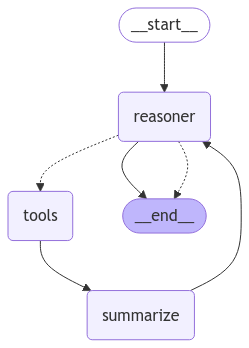

Assistant: Hello! Type 'exit' to end the conversation.
You: how can i make pizza?
Assistant is thinking...
Assistant: 
-----------Lancedb SEARCHING Tool----------
searching for how to make pizza
results                                                 text  \
0  1 cup of water before cooking.)\n   Heart.    ...   
1  Preparing This Food\n   Brains.     First wash...   
2  pry open the shell, strain the liquid for any ...   
3  Preparing This Food\nWash the pumpkin under co...   
4  Preparing This Food\nWash the squash and bake ...   

                  metadata_file_name metadata_creation_date  \
0  The_New_Complete_Book_of_Foos.pdf             2025-02-06   
1  The_New_Complete_Book_of_Foos.pdf             2025-02-06   
2  The_New_Complete_Book_of_Foos.pdf             2025-02-06   
3  The_New_Complete_Book_of_Foos.pdf             2025-02-06   
4  The_New_Complete_Book_of_Foos.pdf             2025-02-06   

   metadata_pagenumber                                             vector  \
0   

KeyboardInterrupt: Interrupted by user

In [37]:
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import MessagesState
from typing import List, TypedDict
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from datetime import datetime
import json

sys_msg = SystemMessage(
    content="""You are a helpful assistant. Engage in a multi-turn conversation and assist the user with their queries.
    You have 5 tools: food_search, order_management, food_recommendation, lancedb_search, web_search.
    - If the user is looking for the availability of a food in a restaurant, use the food_search tool.
    - If the user is looking for general information about food, first use the lancedb_search tool. If the retrieved documents are not related, use the web_search tool.
    - If the user wants a food recommendation but hasn't specified a food name, use the food_recommendation tool.
    - If the user wants order management, use the order_management tool.
    - Be careful, think step by step. If the user requests another operation during an ongoing order management operation, ask them to complete the previous operation first.
    """
)

class SummaryState(TypedDict):
    messages: List[HumanMessage]
    question: str
    answer: str
    summary: str

def reasoner(state: MessagesState):
    print("Assistant is thinking...")
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    print("Assistant:", response.content)
    return {"messages": [response]}

def summarize(state: MessagesState) -> MessagesState:
    summary_prompt = HumanMessage(content="""
    Summarize the above conversation while preserving full context, key points, and user intent.
    Your response should be concise yet informative.
    """)

    messages = state.get("messages", []) + [summary_prompt]
    response = llm_with_tools.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"messages": delete_messages + [response]}

builder = StateGraph(MessagesState)
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize", summarize)

builder.add_edge(START, "reasoner")
builder.add_conditional_edges("reasoner", tools_condition)
builder.add_edge("tools", "summarize")
builder.add_edge("summarize", "reasoner")
builder.add_edge("reasoner", END)

react_graph = builder.compile()

from IPython.display import Image, display

LOG_FILE = "/content/drive/My Drive/nlp_ca6/foods_information.txt"

def save_log(messages, metadata=None):
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write("\n--- New Interaction ---\n")
        f.write(f"Timestamp: {datetime.utcnow().isoformat()}\n")

        for msg in messages:
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            f.write(f"{role}: {msg.content}\n")

        if metadata and metadata.get("tool_calls"):
            f.write(f"Tool Calls: {json.dumps(metadata['tool_calls'], ensure_ascii=False)}\n")

        f.write("\n")

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

while True:
    messages = [sys_msg]
    print("Assistant: Hello! Type 'exit' to end the conversation.")

    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("\nConversation ended.")
            break

        messages.append(HumanMessage(content=user_input))
        result = react_graph.invoke({"messages": messages})

        messages.append(result["messages"][-1])

        this_time_messages = messages.copy()
        metadata = {"tool_calls": result["messages"][-1].additional_kwargs.get("tool_calls", [])}

        save_log(this_time_messages, metadata)

## UI


در این قسمت هم از کد موجود در ورک شاپ برای ایجاد اپلیکیشن و هویت بصری چت بات استفاده کردم به این صورت که :
از MemorySaver برای ذخیره اطلاعات مکالمه استفاده شده است.
graph با استفاده از builder.compile(checkpointer=memory) مقداردهی اولیه شده است.
سپس در ابتدای چت چت، مدل graph به عنوان چت‌ بات تنظیم می‌شود و پیام مشخص شده که چت بات خودش را معرفی میکند به کاربر نمایش داده می شود.
سپس وقتی کاربر پیامی ارسال میکند تابع on_message اجزا میشود و بعد از پردازش پیام های ورودی و حورجی و پردازش و استریم پاسخ ها به ترتیب:
پیام کاربر به گراف پردازشگر ارسال می‌شود.
مدل پاسخ می‌دهد و در this_time_messages ذخیره می‌شود.	اگر پیام از نوع AIMessage باشد، محتوای آن به صورت استریم می‌شود. درنهایت هم پیام های این سشن در cl.user_session ذخیره میشود و پاسخ نهایی به کاربر ارسال می شود.


In [ ]:
import chainlit as cl
from ReAct_graph import builder
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema.runnable.config import RunnableConfig

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

@cl.on_chat_start
async def on_chat_start():

    model = graph
    cl.user_session.set("runnable", model)
    await cl.Message(content="Hello! I am a ChatFood.Im here to help you in foods world.  How can I help you?").send()

@cl.on_message
async def on_message(message: cl.Message):

    config = {"configurable": {"thread_id": cl.context.session.id}}
    cb = cl.LangchainCallbackHandler()

    final_answer = cl.Message(content="")
    this_time_messages = []

    for msg, metadata in graph.stream(
        {"messages": HumanMessage(content=message.content)},
        stream_mode="messages",
        config=RunnableConfig(callbacks=[cb], **config)
    ):
        this_time_messages.append(msg)
        if isinstance(msg, AIMessage):
            await final_answer.stream_token(msg.content)

    cl.user_session.set("messages", this_time_messages)
    await final_answer.send()

## سوالات
<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
چرا داده ها را  chunk میکنیم؟

دلیل chunk کردن داده ها این است که ابزار  parser هر صفحه فایل پی دی اف ما را یک مجموعه داده در نظر میگیرد و در صورتی که داد ها را chunk نکنیم هر صفحه از فایل در یک سطر دیتا بیس قرار میگیرد که در این صورت هم ممکن از جستجو سخت بشود و هم اینکه جستجوی ما کلی تر شود. همچنین با توجه به استفاده از دیتابیس  lancedb و با توجه به این که این دیتا بیس شباهت بین کوئری و اسناد را با استفاده از نزدیکی بردار امبدینگ ان ها اندازه گیری میکند اگر داده ها را  chunk نکنیم برای حجم زیادی از داده ها یک بردار خواهیم داشت که در این صورت ممکن از معنای بردار امبدینگ در آن کانتکست کمی تغییر کند و این بردار نماینده خوبی برای داده ها نباشد.

------------------------------------------------

چرا بهتر است بازیابی ترکیبی باشد؟ بازیابی ترکیبی به چه معناست؟

در اینجا به نظر من بازیابی ترکیبی به معنای استفاده از منابع معتبر مثل کتاب و منابع درون وب است. بازیابی ترکیبی از این لحاظ خوب است که اولا ما میتوانیم با سرعت بالایی منابع معتبر محدود خود مثل کتاب ها را جستجو کنیم و ثانیا اگر مطالب مرتبط با کوئری در منابع نبود می توان با استفاده از جستجو در وب مطالب مورد نیاز را پیدا کنیم. استفاده از این دو بازیابی به تنهایی دارای مشکلاتی است اولا اینکه استفاده از بازیابی در منایعی مثل کتاب ها. و اسناد نیاز مند دیتابیس بزرگی است و استفاده از اینترنت به تنهایی نیز ممکن است دقت کافی را نداشته باشد.


-----------------------------------------------


چرا قبل از تولید پاسخ کانکست های جستجو شده را فیلتر میکنیم؟


به نظرم من به دلیل اینکه ممکن است اسناد بازیابی شده به قدر کافی با سوال کاربر مرتبط نباشند و یا اینکه صرفا بخشی از آن اسناد با کوئری کاربر مرتبط باشد در نتیجه اگر این فیلتر کردن صورت نگیرد ممکن است مدل بر اساس اسناد و یا فرضیات اشتباه جنریت کلمات را انجام دهد.


------------------------------------------------


چرا از RAG استفاده میکنیم؟


به دلیل اینکه اولا دانش llm ها محدود است و بسته به زمانی که آموزش دیده شدند دارد یعنی llm ها نمیتوانند درباره اطلاعاتی که بعد از آموزش آن ها تولید شده پاسخ صحیح بدهند. همچنین llm ها دچار هالوسینیشن هستند و حتی برای مسائلی که نمیدانند هم جواب جنریت میکنند و به این موضوع اهمیت نمی دهند که آیا ان پاسخ صحیح است یا نه به همین دلیل ما با استفاده از RAG و با متد های بازیابی اطلاعات، اطلاعات مربوط به آن درخواست را بازیابی میکنیم و آن ها را دراختیار مدل قرار میدهیم و از مدل میخوایم با توجه به این اطلاعات به سوالات پاسخ دهند.